<a href="https://colab.research.google.com/github/sarojkhanal-git/CBEAS_Whole_brain_and_Hippocampal_Segmentation/blob/main/Full_TUNING_Hippo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Libraries Import

In [ ]:
import pandas as pd

In [ ]:
%pip install "monai==1.4.1rc1" -q
#%pip install torchinfo -q
#%pip install thop -q

In [ ]:
!pip install numpy==1.24.3

In [ ]:
import glob
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime


import nibabel as nib
import torch
import torch.nn as nn
import torch.optim as optim


from monai.config import print_config
from monai.metrics import DiceMetric
from monai.data import DataLoader, Dataset, decollate_batch
from monai.losses import DiceLoss
from monai.networks.nets import SwinUNETR
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    Resize,
    ScaleIntensity,
    ToTensor,
    Lambda,
    EnsureType,
)
from monai.utils import set_determinism
from monai.inferers import sliding_window_inference


#from torchinfo import summary
#from thop import profile


from google.colab import drive
print_config()

MONAI version: 1.4.1rc1
Numpy version: 1.24.3
Pytorch version: 2.6.0+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: e604d1841fe60c0ffb6978ae4116535ca8d8f34f
MONAI __file__: /usr/local/lib/python3.11/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.25.2
scipy version: 1.14.1
Pillow version: 11.1.0
Tensorboard version: 2.18.0
gdown version: 5.2.0
TorchVision version: 0.21.0+cu124
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.2.2
einops version: 0.8.1
transformers version: 4.50.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/e

##Drive Mount

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Image, Label and FreeSurferColorLUT Directory

In [ ]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
image_dir = "MNI_train_data/image_files"
label_dir = "MNI_train_data/label_files_combined"

In [ ]:
lut_path = "FreeSurferColorLUT.txt"

##Image & Labels Extraction and Visualization

In [ ]:
images = sorted(glob.glob(os.path.join(image_dir, "*.nii.gz")))
labels = sorted(glob.glob(os.path.join(label_dir, "*.nii.gz")))

In [ ]:
len(images), len(labels)

(25, 25)

In [ ]:
def visualize_image(mri_image, label_image, slice_num, array = False):

  if array == False:
    mri_image = nib.load(mri_image).get_fdata()
    label_image =nib.load(label_image).get_fdata()

  df = pd.read_csv(lut_path,sep='\s+', comment = '#', names = ['Label_ID', 'Label_Name', 'R', 'G', 'B', 'A'], usecols = ['Label_ID', 'Label_Name', 'R', 'G', 'B'])

  unique_labels = np.unique(label_image)

  rgb_img = np.zeros((*label_image.shape, 3), dtype = np.uint8)

  for labels in unique_labels:
     rgb_values = df.loc[df['Label_ID'] == labels, ['R', 'G', 'B']].values[0]
     rgb_img[label_image == labels] = rgb_values

  fig, axs = plt.subplots(1, 3, figsize = (15, 15))
  axs[0].imshow(mri_image[slice_num,: ,:], cmap = 'gray')
  axs[0].set_title('MRI Slice')
  axs[0].axis('off')

  axs[1].imshow(rgb_img[slice_num, :, :, :])
  axs[1].set_title('Label Slice')
  axs[1].axis('off')

  axs[2].imshow(mri_image[slice_num, :, :], cmap = 'gray')
  axs[2].imshow(rgb_img[slice_num, :, :, :], alpha = 0.5)
  axs[2].set_title('Overlay')
  axs[2].axis('off')

  plt.show()




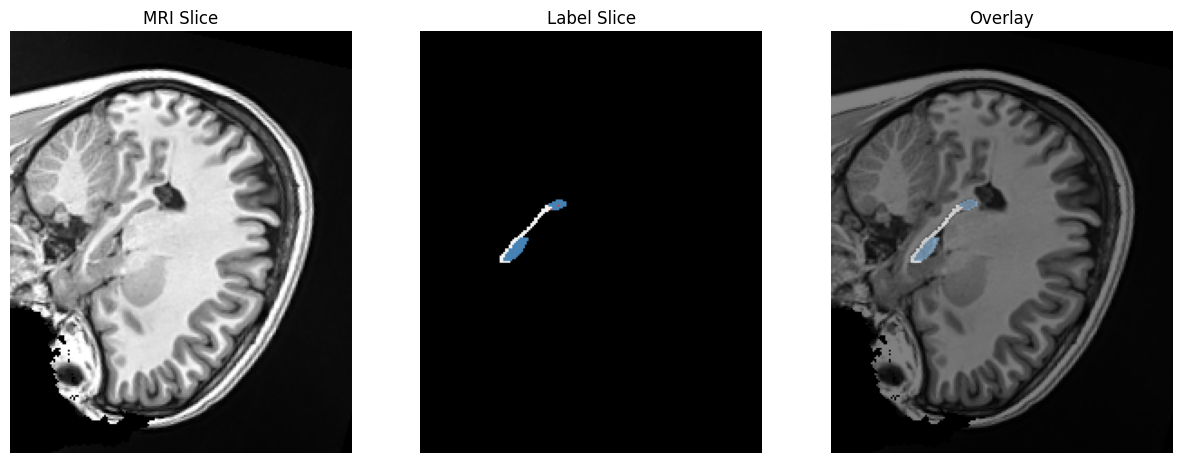

In [ ]:
visualize_image(images[0],labels[0], 75)

##Image Transforms and Custom Dataset

####Transforms

In [ ]:
from monai.transforms import SpatialCrop, CenterSpatialCrop

In [ ]:
img_transforms = Compose([
    LoadImage(image_only=True),
    ToTensor(),
    ScaleIntensity(),
    EnsureChannelFirst(),
    #SpatialCrop(roi_center= (98, 122, 55), roi_size=(128, 128, 128)) #(197, 189, 233)
    CenterSpatialCrop(roi_size=(160, 160, 160))
])

seg_transforms = Compose([
    LoadImage(image_only=True),
    ToTensor(),
    EnsureChannelFirst(),
    #SpatialCrop(roi_center= (98, 122, 55), roi_size=(128, 128, 128)) #(197, 189, 233)
    CenterSpatialCrop(roi_size=(160, 160, 160))
])


In [ ]:
class MyBrainDataset(Dataset):
    def __init__(self, data, img_tfms, seg_tfms):
        super().__init__(data)
        self.img_tfms = img_tfms
        self.seg_tfms = seg_tfms

    def __getitem__(self, idx):
        d = self.data[idx]
        image = self.img_tfms(d["image"])
        label = self.seg_tfms(d["label"])
        return image, label


##Dataset Loading

In [ ]:
data_dicts = [{"image": i, "label": s} for i, s in zip(images, labels)]
train_files = data_dicts[:20]
val_files   = data_dicts[20:]


In [ ]:
train_ds = MyBrainDataset(train_files, img_transforms, seg_transforms)
val_ds   = MyBrainDataset(val_files,   img_transforms, seg_transforms)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=1, shuffle=False, num_workers=2)

In [ ]:
imgt, segt = train_ds[0]
imgt = imgt.squeeze().numpy()
segt = segt.squeeze().numpy()
imgt.shape, segt.shape

((160, 160, 160), (160, 160, 160))

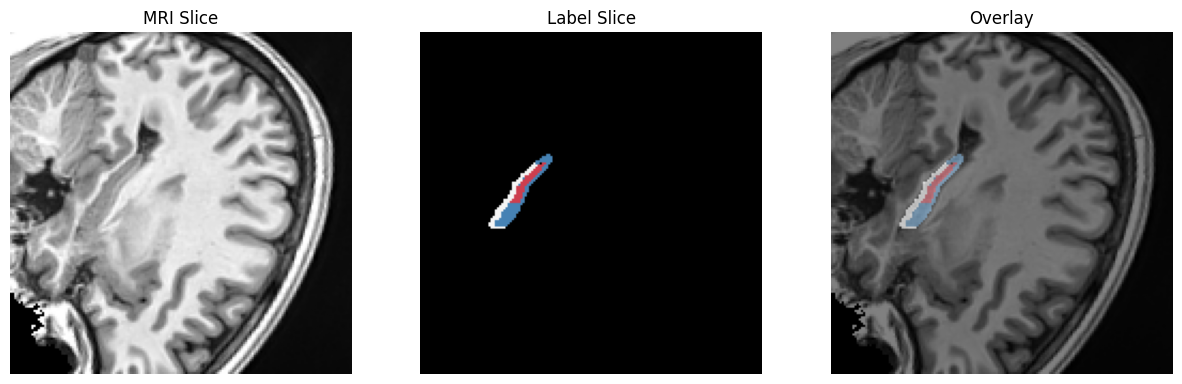

In [ ]:
visualize_image(imgt, segt, 50, array = True)

##Model, Optimizer and Loss Function

In [ ]:
from monai.losses import DiceCELoss

In [ ]:
set_determinism(seed=40)

num_classes = 4

model = SwinUNETR(
    img_size=(160, 160, 160),
    in_channels=1,
    out_channels=num_classes,
    feature_size=24,
    use_checkpoint=True

).cuda()


/usr/local/lib/python3.11/dist-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


##Loading Pre-Trained Model

In [ ]:
len(model.state_dict())

159

In [ ]:
pretrained_dict = torch.load('160_24fs_lr-3_best_dice_model.pth')
model_dict = model.state_dict()

# Count total parameters in both models
total_pretrained_params = len(pretrained_dict)
total_current_params = len(model_dict)

# Check which parameters match in name
name_matches = [k for k in pretrained_dict.keys() if k in model_dict]
print(f"Parameters matching by name: {len(name_matches)} out of {total_pretrained_params}")

# Check which parameters match in both name and shape
filtered_dict = {
    k: v
    for k, v in pretrained_dict.items()
    if k in model_dict and model_dict[k].shape == v.shape
}

# Print statistics
print(f"Parameters matching by name and shape: {len(filtered_dict)} out of {total_pretrained_params}")
print(f"Parameters that will NOT be updated: {total_current_params - len(filtered_dict)} out of {total_current_params}")

# Print the specific layers that will NOT be updated
non_updated_layers = [k for k in model_dict.keys() if k not in filtered_dict]
print("\nLayers that will NOT be updated:")
for layer in non_updated_layers:
    print(f"- {layer} with shape {model_dict[layer].shape}")

# Update and load as before
model_dict.update(filtered_dict)
model.load_state_dict(model_dict)
print("\nModel successfully updated!")

Parameters matching by name: 159 out of 159
Parameters matching by name and shape: 157 out of 159
Parameters that will NOT be updated: 2 out of 159

Layers that will NOT be updated:
- out.conv.conv.weight with shape torch.Size([4, 24, 1, 1, 1])
- out.conv.conv.bias with shape torch.Size([4])

Model successfully updated!


#Adapter Layer

##Model Details

In [ ]:

loss_function = DiceCELoss(to_onehot_y=True, softmax=True, lambda_dice=0.7, lambda_ce=0.3, include_background=True)

trainable_params = [param for param in model.parameters() if param.requires_grad]
optimizer = torch.optim.AdamW(trainable_params, lr=1e-3)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 50, 70], gamma=0.1)

dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

post_trans = Compose([
    Activations(softmax=True),
    AsDiscrete(argmax=True, to_onehot=num_classes)
])


In [ ]:
#summary(model, input_size=(1, 1, 128, 128, 128))

In [ ]:
'''
input_tensor = torch.randn(1, 1, 128, 128, 128)
flops, params = profile(model, inputs=(input_tensor,))
print(f"FLOPs: {flops}")
print(f"Parameters: {params}")
'''

'\ninput_tensor = torch.randn(1, 1, 128, 128, 128)\nflops, params = profile(model, inputs=(input_tensor,))\nprint(f"FLOPs: {flops}")\nprint(f"Parameters: {params}")\n'

##Functions to load and save model and checkpoints

In [ ]:
def save_best_model(model, best_model_path):
    torch.save(model.state_dict(), best_model_path)

In [ ]:
def load_model(model, path):
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

In [ ]:
def save_checkpoint(epoch, model, optimizer, loss, dice_mean, epoch_list, val_dice_list, train_loss_list, best_metric, best_metric_epoch, checkpoint_path):
    checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
    'dice_mean': dice_mean,
    'epoch_list' : epoch_list,
    'val_dice_list' : val_dice_list,
    'train_loss_list' : train_loss_list,
    'best_metric': best_metric,
    'best_metric_epoch': best_metric_epoch,
    }
    torch.save(checkpoint, checkpoint_path)


In [ ]:
def load_checkpoint(path):
    checkpoint = torch.load(path, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    dice_mean = checkpoint['dice_mean']
    epoch_list = checkpoint['epoch_list']
    val_dice_list = checkpoint['val_dice_list']
    train_loss_list = checkpoint['train_loss_list']
    best_metric = checkpoint['best_metric']
    best_metric_epoch = checkpoint['best_metric_epoch']
    return epoch, model, optimizer, loss, dice_mean, epoch_list, val_dice_list, train_loss_list, best_metric, best_metric_epoch

##Load Checkpoint

In [ ]:
#epoch, model, optimizer, loss, dice_mean, epoch_list, val_dice_list, train_loss_list, best_metric, best_metric_epoch = load_checkpoint('adapter1_res_Checkpoint.pth')

##Epochs and Validation

In [ ]:
max_epochs = 80
val_interval = 1

###Run if Checkpoints are not loaded

In [ ]:
train_loss_list = []
val_dice_list   = []
epoch_list      = []
epoch=0
dice_mean = -1
best_metric = -1
best_metric_epoch = -1

##Train and Validation Loop

In [ ]:
from tqdm import tqdm

In [ ]:
start_epoch=epoch

In [ ]:
checkpoint_path = 'Train_Data_INFO/Full_tuning_Checkpoint.pth'
best_model_path = 'Train_Data_INFO/Full_tuning_best_dice_model.pth'

#Training Loop
for epoch in range(max_epochs):
    print(f"Epoch [{epoch+1}/{max_epochs}] {datetime.datetime.now()}")
    model.train()
    epoch_loss = 0

    for batch_data in tqdm(train_loader, leave=False):
        inputs, label = batch_data[0].cuda(), batch_data[1].cuda()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    #scheduler.step()
    train_loss_list.append(epoch_loss)
    print(f"  Train loss: {epoch_loss:.4f}")



    # Validation Loop
    if (epoch + 1) % val_interval == 0:
        model.eval()
        dice_vals = []
        with torch.no_grad():
            for val_data in tqdm(val_loader, leave=False):
                val_inputs, val_labels = val_data[0].cuda(), val_data[1].cuda()
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model, mode="gaussian", overlap=0.5)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)


        dice_mean = dice_metric.aggregate().item()
        dice_metric.reset()
        val_dice_list.append(dice_mean)
        epoch_list.append(epoch + 1)
        print(f"  Validation Dice: {dice_mean:.4f}")

        # Save the best model
        if dice_mean > best_metric:
            best_metric = dice_mean
            best_metric_epoch = epoch + 1
            save_best_model(model, best_model_path)
            print("   Saved new best model")

    save_checkpoint(epoch, model, optimizer, loss, dice_mean, epoch_list, val_dice_list, train_loss_list, best_metric, best_metric_epoch, checkpoint_path)
print(f"\nTraining complete. Best val Dice: {best_metric:.4f} at epoch {best_metric_epoch}")

Epoch [1/80] 2025-04-03 09:40:15.877678


  Train loss: 1.0701


  Validation Dice: 0.2122
   Saved new best model
Epoch [2/80] 2025-04-03 09:41:07.436284


  Train loss: 0.8113


  Validation Dice: 0.2643
   Saved new best model
Epoch [3/80] 2025-04-03 09:41:52.690806


  Train loss: 0.7224


  Validation Dice: 0.3528
   Saved new best model
Epoch [4/80] 2025-04-03 09:42:37.881082


  Train loss: 0.6683


  Validation Dice: 0.3722
   Saved new best model
Epoch [5/80] 2025-04-03 09:43:23.009426


  Train loss: 0.6296


  Validation Dice: 0.3784
   Saved new best model
Epoch [6/80] 2025-04-03 09:44:08.264109


  Train loss: 0.6016


  Validation Dice: 0.4883
   Saved new best model
Epoch [7/80] 2025-04-03 09:44:53.352112


  Train loss: 0.5796


  Validation Dice: 0.4836
Epoch [8/80] 2025-04-03 09:45:38.223564


  Train loss: 0.5607


  Validation Dice: 0.4929
   Saved new best model
Epoch [9/80] 2025-04-03 09:46:23.359073


  Train loss: 0.5426


  Validation Dice: 0.5059
   Saved new best model
Epoch [10/80] 2025-04-03 09:47:08.630374


  Train loss: 0.5221


  Validation Dice: 0.5254
   Saved new best model
Epoch [11/80] 2025-04-03 09:47:53.877594


  Train loss: 0.4946


  Validation Dice: 0.5735
   Saved new best model
Epoch [12/80] 2025-04-03 09:48:39.117474


  Train loss: 0.4616


  Validation Dice: 0.5631
Epoch [13/80] 2025-04-03 09:49:24.057329


  Train loss: 0.4224


  Validation Dice: 0.5689
Epoch [14/80] 2025-04-03 09:50:08.961354


  Train loss: 0.3841


  Validation Dice: 0.5955
   Saved new best model
Epoch [15/80] 2025-04-03 09:50:55.134913


  Train loss: 0.3495


  Validation Dice: 0.5965
   Saved new best model
Epoch [16/80] 2025-04-03 09:51:40.906048


  Train loss: 0.3188


  Validation Dice: 0.6080
   Saved new best model
Epoch [17/80] 2025-04-03 09:52:26.912318


  Train loss: 0.3015


  Validation Dice: 0.6089
   Saved new best model
Epoch [18/80] 2025-04-03 09:53:12.163687


  Train loss: 0.2878


  Validation Dice: 0.6056
Epoch [19/80] 2025-04-03 09:53:57.076250


  Train loss: 0.2798


  Validation Dice: 0.6153
   Saved new best model
Epoch [20/80] 2025-04-03 09:54:42.274756


  Train loss: 0.2692


  Validation Dice: 0.6175
   Saved new best model
Epoch [21/80] 2025-04-03 09:55:27.458473


  Train loss: 0.2633


  Validation Dice: 0.6491
   Saved new best model
Epoch [22/80] 2025-04-03 09:56:12.637093


  Train loss: 0.2553


  Validation Dice: 0.6954
   Saved new best model
Epoch [23/80] 2025-04-03 09:56:57.813686


  Train loss: 0.2443


  Validation Dice: 0.7663
   Saved new best model
Epoch [24/80] 2025-04-03 09:57:43.033767


  Train loss: 0.2354


  Validation Dice: 0.7680
   Saved new best model
Epoch [25/80] 2025-04-03 09:58:28.343139


  Train loss: 0.2304


  Validation Dice: 0.7846
   Saved new best model
Epoch [26/80] 2025-04-03 09:59:13.552274


  Train loss: 0.2189


  Validation Dice: 0.7818
Epoch [27/80] 2025-04-03 09:59:58.556556


  Train loss: 0.2068


  Validation Dice: 0.8030
   Saved new best model
Epoch [28/80] 2025-04-03 10:00:43.841185


  Train loss: 0.1922


  Validation Dice: 0.8088
   Saved new best model
Epoch [29/80] 2025-04-03 10:01:29.118924


  Train loss: 0.1732


  Validation Dice: 0.8038
Epoch [30/80] 2025-04-03 10:02:14.116037


  Train loss: 0.1490


  Validation Dice: 0.8147
   Saved new best model
Epoch [31/80] 2025-04-03 10:02:59.406904


  Train loss: 0.1324


  Validation Dice: 0.8129
Epoch [32/80] 2025-04-03 10:03:44.359148


  Train loss: 0.1137


  Validation Dice: 0.8273
   Saved new best model
Epoch [33/80] 2025-04-03 10:04:29.762948


  Train loss: 0.1025


  Validation Dice: 0.8302
   Saved new best model
Epoch [34/80] 2025-04-03 10:05:14.948675


  Train loss: 0.0967


  Validation Dice: 0.8263
Epoch [35/80] 2025-04-03 10:06:00.835348


  Train loss: 0.0959


  Validation Dice: 0.8244
Epoch [36/80] 2025-04-03 10:06:46.258849


  Train loss: 0.0881


  Validation Dice: 0.8219
Epoch [37/80] 2025-04-03 10:07:31.257305


  Train loss: 0.0864


  Validation Dice: 0.8147
Epoch [38/80] 2025-04-03 10:08:16.566409


  Train loss: 0.0817


  Validation Dice: 0.8308
   Saved new best model
Epoch [39/80] 2025-04-03 10:09:01.803469


  Train loss: 0.0778


  Validation Dice: 0.8238
Epoch [40/80] 2025-04-03 10:09:46.755424


  Train loss: 0.0739


  Validation Dice: 0.8227
Epoch [41/80] 2025-04-03 10:10:31.740900


  Train loss: 0.0695


  Validation Dice: 0.8309
   Saved new best model
Epoch [42/80] 2025-04-03 10:11:16.988835


  Train loss: 0.0704


  Validation Dice: 0.8345
   Saved new best model
Epoch [43/80] 2025-04-03 10:12:02.257843


  Train loss: 0.0727


  Validation Dice: 0.8271
Epoch [44/80] 2025-04-03 10:12:47.208639


  Train loss: 0.0715


  Validation Dice: 0.8362
   Saved new best model
Epoch [45/80] 2025-04-03 10:13:32.428191


  Train loss: 0.0673


  Validation Dice: 0.8370
   Saved new best model
Epoch [46/80] 2025-04-03 10:14:18.549408


  Train loss: 0.0684


  Validation Dice: 0.8316
Epoch [47/80] 2025-04-03 10:15:04.115509


  Train loss: 0.0629


  Validation Dice: 0.8278
Epoch [48/80] 2025-04-03 10:15:49.010946


  Train loss: 0.0613


  Validation Dice: 0.8346
Epoch [49/80] 2025-04-03 10:16:33.898543


  Train loss: 0.0584


  Validation Dice: 0.8300
Epoch [50/80] 2025-04-03 10:17:18.812402


  Train loss: 0.0590


  Validation Dice: 0.8321
Epoch [51/80] 2025-04-03 10:18:03.623277


  Train loss: 0.0578


  Validation Dice: 0.8300
Epoch [52/80] 2025-04-03 10:18:48.430173


  Train loss: 0.0608


  Validation Dice: 0.8372
   Saved new best model
Epoch [53/80] 2025-04-03 10:19:33.382878


  Train loss: 0.0596


  Validation Dice: 0.8383
   Saved new best model
Epoch [54/80] 2025-04-03 10:20:19.298274


  Train loss: 0.0566


  Validation Dice: 0.8292
Epoch [55/80] 2025-04-03 10:21:04.171851


  Train loss: 0.0563


  Validation Dice: 0.8279
Epoch [56/80] 2025-04-03 10:21:49.142937


  Train loss: 0.0607


  Validation Dice: 0.8332
Epoch [57/80] 2025-04-03 10:22:34.155022


  Train loss: 0.0597


  Validation Dice: 0.8316
Epoch [58/80] 2025-04-03 10:23:19.136895


  Train loss: 0.0521


  Validation Dice: 0.8330
Epoch [59/80] 2025-04-03 10:24:04.089564


  Train loss: 0.0490


  Validation Dice: 0.8352
Epoch [60/80] 2025-04-03 10:24:48.973826


  Train loss: 0.0485


  Validation Dice: 0.8294
Epoch [61/80] 2025-04-03 10:25:33.981934


  Train loss: 0.0484


  Validation Dice: 0.8347
Epoch [62/80] 2025-04-03 10:26:19.640711


  Train loss: 0.0495


  Validation Dice: 0.8365
Epoch [63/80] 2025-04-03 10:27:05.473010


  Train loss: 0.0489


  Validation Dice: 0.8390
   Saved new best model
Epoch [64/80] 2025-04-03 10:27:50.692875


  Train loss: 0.0486


  Validation Dice: 0.8369
Epoch [65/80] 2025-04-03 10:28:35.633975


  Train loss: 0.0479


  Validation Dice: 0.8368
Epoch [66/80] 2025-04-03 10:29:20.611282


  Train loss: 0.0490


  Validation Dice: 0.8358
Epoch [67/80] 2025-04-03 10:30:05.641793


  Train loss: 0.0511


  Validation Dice: 0.8336
Epoch [68/80] 2025-04-03 10:30:50.651910


  Train loss: 0.0544


  Validation Dice: 0.8289
Epoch [69/80] 2025-04-03 10:31:35.590827


  Train loss: 0.0508


  Validation Dice: 0.8330
Epoch [70/80] 2025-04-03 10:32:21.155152


  Train loss: 0.0467


  Validation Dice: 0.8329
Epoch [71/80] 2025-04-03 10:33:06.720009


  Train loss: 0.0442


  Validation Dice: 0.8352
Epoch [72/80] 2025-04-03 10:33:51.726570


  Train loss: 0.0431


  Validation Dice: 0.8302
Epoch [73/80] 2025-04-03 10:34:36.698755


  Train loss: 0.0434


  Validation Dice: 0.8377
Epoch [74/80] 2025-04-03 10:35:21.652250


  Train loss: 0.0428


  Validation Dice: 0.8356
Epoch [75/80] 2025-04-03 10:36:06.616852


  Train loss: 0.0424


  Validation Dice: 0.8372
Epoch [76/80] 2025-04-03 10:36:51.554123


  Train loss: 0.0440


  Validation Dice: 0.8384
Epoch [77/80] 2025-04-03 10:37:36.536065


  Train loss: 0.0439


  Validation Dice: 0.8385
Epoch [78/80] 2025-04-03 10:38:22.042932


  Train loss: 0.0429


  Validation Dice: 0.8295
Epoch [79/80] 2025-04-03 10:39:07.559444


  Train loss: 0.0412


  Validation Dice: 0.8351
Epoch [80/80] 2025-04-03 10:39:52.508091


  Train loss: 0.0398


  Validation Dice: 0.8351

Training complete. Best val Dice: 0.8390 at epoch 63


##Plotting of Loss Curves

In [ ]:
len(train_loss_list), len(val_dice_list), len(epoch_list)

(80, 80, 80)

In [ ]:
from matplotlib import rcParams

rcParams['font.weight'] = 'bold'

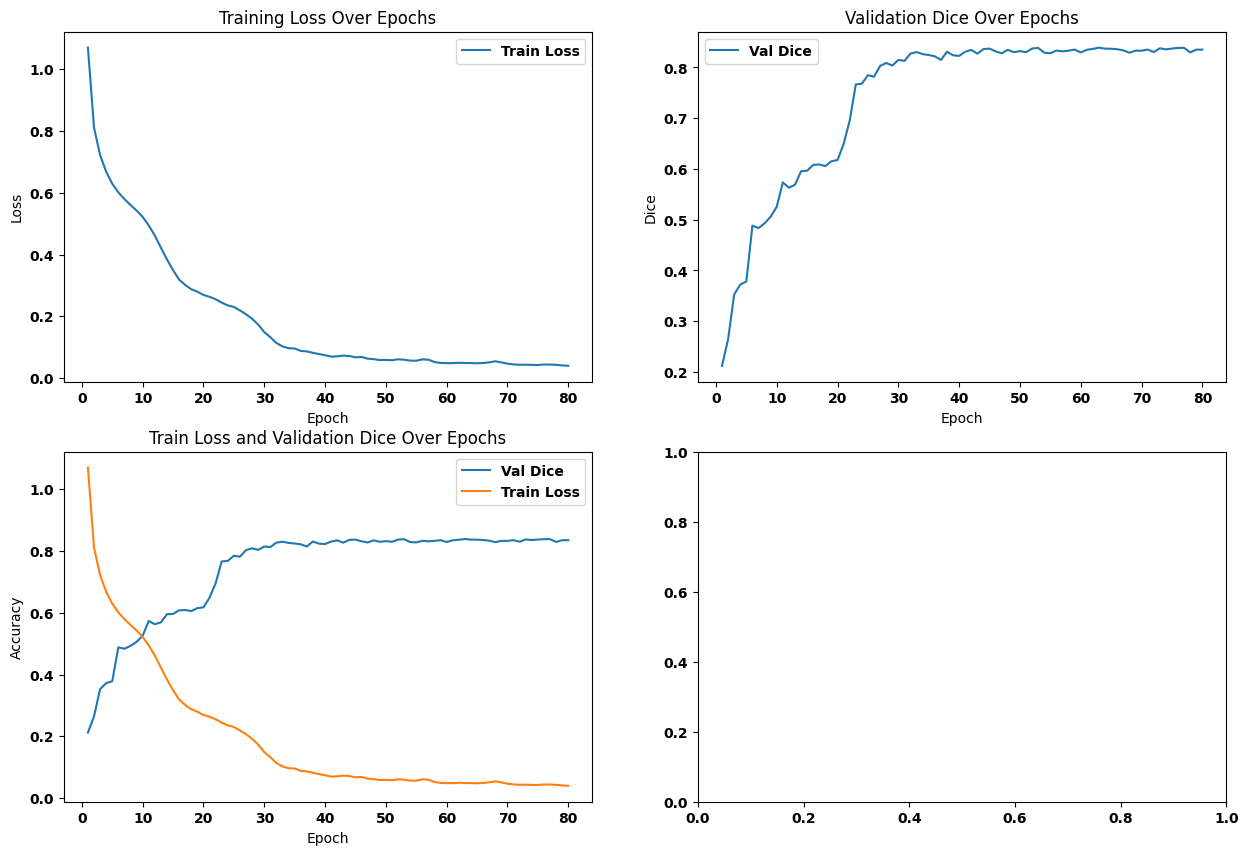

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0 ,0].plot(range(1, max_epochs+1), train_loss_list, label="Train Loss")
axs[0, 0].set_xlabel("Epoch")
axs[0, 0].set_ylabel("Loss")
axs[0, 0].set_title("Training Loss Over Epochs")
axs[0, 0].legend()

axs[0, 1].plot(epoch_list, val_dice_list, label="Val Dice")
axs[0, 1].set_xlabel("Epoch")
axs[0, 1].set_ylabel("Dice")
axs[0, 1].set_title("Validation Dice Over Epochs")
axs[0, 1].legend()

"""
axs[1, 0].plot(range(1, max_epochs+1), 1 - np.array(train_loss_list[:]), label="Train Accuracy")
axs[1, 0].set_xlabel("Epoch")
axs[1, 0].set_ylabel("Accuracy")
axs[1, 0].set_title("Training Accuracy Over Epochs")
axs[1, 0].legend()
"""

axs[1, 0].plot(epoch_list, val_dice_list, label="Val Dice")
axs[1, 0].plot(range(1, max_epochs+1), train_loss_list, label="Train Loss")
axs[1, 0].set_xlabel("Epoch")
axs[1, 0].set_ylabel("Accuracy")
axs[1, 0].set_title("Train Loss and Validation Dice Over Epochs")
axs[1, 0].legend()

plt.show()

In [ ]:

df = pd.DataFrame({'Max_Epoch': epoch,
                     "Epoch_list": epoch_list,
                     "Validation_List": val_dice_list,
                     "Train_Loss_List": train_loss_list,
                     "Best_Dice": best_metric,
                     "Best_Dice_Epoch": best_metric_epoch})

file_path = "Train_Data_INFO/Full_tuning_data_info.csv"

df.to_csv(file_path, index=False)
print(f"File saved to: {os.path.abspath(file_path)}")

File saved to: /content/drive/MyDrive/Train_Data_INFO/Full_tuning_data_info.csv


##Model Evaluation

In [ ]:
model.load_state_dict(torch.load(best_model_path))
model.eval()

def dice_score(pred, target, num_classes):
    """
    Calculate Dice score for each class and the combined hippocampus structure.

    Args:
        pred (torch.Tensor): Predicted class indices, shape [batch_size, H, W, D].
        target (torch.Tensor): Ground truth class indices, shape [batch_size, H, W, D].
        num_classes (int): Number of classes.

    Returns:
        dice_scores (torch.Tensor): Dice scores for each class, shape [num_classes].
        hippocampus_dice (torch.Tensor): Dice score for the combined hippocampus structure.
    """
    dice_scores = torch.zeros(num_classes, device=pred.device)

    # Calculate Dice for each class
    for class_idx in range(num_classes):
        pred_mask = (pred == class_idx).float()
        target_mask = (target == class_idx).float()

        intersection = (pred_mask * target_mask).sum()
        pred_volume = pred_mask.sum()
        target_volume = target_mask.sum()

        if pred_volume + target_volume == 0:
            dice_scores[class_idx] = 1.0  # If both masks are empty, Dice is 1
        else:
            dice_scores[class_idx] = (2 * intersection) / (pred_volume + target_volume)

    # Calculate Dice for the combined hippocampus structure (CA1, CA4DG, subiculum)
    hippocampus_classes = [1, 2, 3]  # Assuming CA1=1, CA4DG=2, subiculum=3
    pred_hippocampus = torch.zeros_like(pred, device=pred.device)
    target_hippocampus = torch.zeros_like(target, device=target.device)

    for class_idx in hippocampus_classes:
        pred_hippocampus = pred_hippocampus + (pred == class_idx).float()
        target_hippocampus = target_hippocampus + (target == class_idx).float()

    # Binarize the combined masks
    pred_hippocampus = (pred_hippocampus > 0).float()
    target_hippocampus = (target_hippocampus > 0).float()

    # Calculate Dice for the combined hippocampus
    intersection = (pred_hippocampus * target_hippocampus).sum()
    pred_volume = pred_hippocampus.sum()
    target_volume = target_hippocampus.sum()

    if pred_volume + target_volume == 0:
        hippocampus_dice = 1.0  # If both masks are empty, Dice is 1
    else:
        hippocampus_dice = (2 * intersection) / (pred_volume + target_volume)

    return dice_scores, hippocampus_dice

# Example usage
model.eval()
test_dice_list = []
class_dice = {'hippocampus': [], 'CA1': [], 'CA4DG': [], 'subiculum': []}

with torch.no_grad():
    for val_data in val_loader:
        val_inputs, val_labels = val_data[0].cuda(), val_data[1].cuda()
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model, mode="gaussian", overlap=0.5)

        # Convert logits to class indices
        val_outputs = torch.argmax(val_outputs, dim=1)  # Shape: [batch_size, H, W, D]

        # Calculate Dice scores for each class and the combined hippocampus
        dice_scores, hippocampus_dice = dice_score(val_outputs, val_labels, num_classes=4)

        # Store scores
        class_dice['hippocampus'].append(hippocampus_dice.item())
        class_dice['CA1'].append(dice_scores[1].item())
        class_dice['CA4DG'].append(dice_scores[2].item())
        class_dice['subiculum'].append(dice_scores[3].item())

        dice_mean = dice_scores.mean().item()
        test_dice_list.append(dice_mean)

        print(f"Validation Dice - Mean: {dice_mean:.4f}")
        print(f"Hippocampus: {class_dice['hippocampus'][-1]:.4f}, "
              f"CA1: {class_dice['CA1'][-1]:.4f}, "
              f"CA4DG: {class_dice['CA4DG'][-1]:.4f}, "
              f"Subiculum: {class_dice['subiculum'][-1]:.4f}")

# Calculate final statistics
def get_stats(values):
    return np.mean(values), np.std(values)

overall_mean, overall_std = get_stats(test_dice_list)
hippocampus_mean, hippocampus_std = get_stats(class_dice['hippocampus'])
ca1_mean, ca1_std = get_stats(class_dice['CA1'])
ca4dg_mean, ca4dg_std = get_stats(class_dice['CA4DG'])
sub_mean, sub_std = get_stats(class_dice['subiculum'])

print("\nFinal Test Dice Scores:")
print(f"Overall: {overall_mean:.4f} ± {overall_std:.4f}")
print(f"Hippocampus: {hippocampus_mean:.4f} ± {hippocampus_std:.4f}")
print(f"CA1: {ca1_mean:.4f} ± {ca1_std:.4f}")
print(f"CA4DG: {ca4dg_mean:.4f} ± {ca4dg_std:.4f}")
print(f"Subiculum: {sub_mean:.4f} ± {sub_std:.4f}")

Validation Dice - Mean: 0.6938
Hippocampus: 0.6583, CA1: 0.5718, CA4DG: 0.5355, Subiculum: 0.6684
Validation Dice - Mean: 0.7607
Hippocampus: 0.6849, CA1: 0.5684, CA4DG: 0.6958, Subiculum: 0.7792
Validation Dice - Mean: 0.7659
Hippocampus: 0.7529, CA1: 0.6660, CA4DG: 0.6893, Subiculum: 0.7090
Validation Dice - Mean: 0.7304
Hippocampus: 0.6947, CA1: 0.5784, CA4DG: 0.6145, Subiculum: 0.7295
Validation Dice - Mean: 0.7503
Hippocampus: 0.7185, CA1: 0.6060, CA4DG: 0.6746, Subiculum: 0.7211

Final Test Dice Scores:
Overall: 0.7402 ± 0.0262
Hippocampus: 0.7019 ± 0.0320
CA1: 0.5981 ± 0.0364
CA4DG: 0.6419 ± 0.0605
Subiculum: 0.7214 ± 0.0357


In [ ]:
model.eval()
test_dice_list = []
with torch.no_grad():
    for val_data in val_loader:
        val_inputs, val_labels = val_data[0].cuda(), val_data[1].cuda()
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model, mode="gaussian", overlap=0.5)
        val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
        dice_metric(y_pred=val_outputs, y=val_labels)

        dice_mean = dice_metric.aggregate().item()
        test_dice_list.append(dice_mean)
        dice_metric.reset()
        print(f"Validation Dice: {dice_mean:.4f}")

test_dice_mean = np.mean(test_dice_list)
std_dev = np.std(test_dice_list)
print(f"\nTest Dice: {test_dice_mean:.4f}, Std Dev: {std_dev:.4f}")

Validation Dice: 0.6938
Validation Dice: 0.7607
Validation Dice: 0.7659
Validation Dice: 0.7304
Validation Dice: 0.7503

Test Dice: 0.7402, Std Dev: 0.0262


In [ ]:
# Load the model
#load_model(model, '/content/drive/MyDrive/Checkpoints/150_epoch_1e-2_best_model.pth')
model.eval()
# Get validation data
val_img, val_seg = val_ds[0]
val_img_ = val_img.unsqueeze(0).cuda()

# Generate prediction
with torch.no_grad():
    pred_logits = model(val_img_)
    # Apply softmax to get probabilities
    pred_probs = torch.softmax(pred_logits, dim=1)
    # Get the class with highest probability
    pred_label = torch.argmax(pred_probs, dim=1, keepdim=True)  # shape [1,1,D,H,W]

# Convert to numpy for visualization
pred_label_np = pred_label.squeeze().cpu().numpy()  # shape [D,H,W]
val_img_np = val_img.squeeze().numpy()              # shape [D,H,W]
val_seg_np = val_seg.squeeze().numpy()              # ground truth

print("Predicted label map shape:", pred_label_np.shape)

Predicted label map shape: (160, 160, 160)


In [ ]:
print(np.unique(pred_label_np), len(np.unique(pred_label_np)))

[0 1 2 3] 4


###Changing contiguous labels to standard labels

In [ ]:
STD_LABEL_VALUES = np.array([0, 2, 3, 4, 5, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 24, 26, 28, 30, 31, 41, 42, 43, 44, 46, 47, 49, 50, 51, 52, 53, 54, 58, 60, 62, 63, 77, 80, 85, 251, 252, 253, 254, 255])

In [ ]:
std_pred_label = STD_LABEL_VALUES[pred_label_np]
std_val_seg = STD_LABEL_VALUES[val_seg_np.astype('int')]

In [ ]:
np.unique(std_pred_label)

array([0, 2, 3, 4])

###Visualization of Predicted and Ground Truth Labels

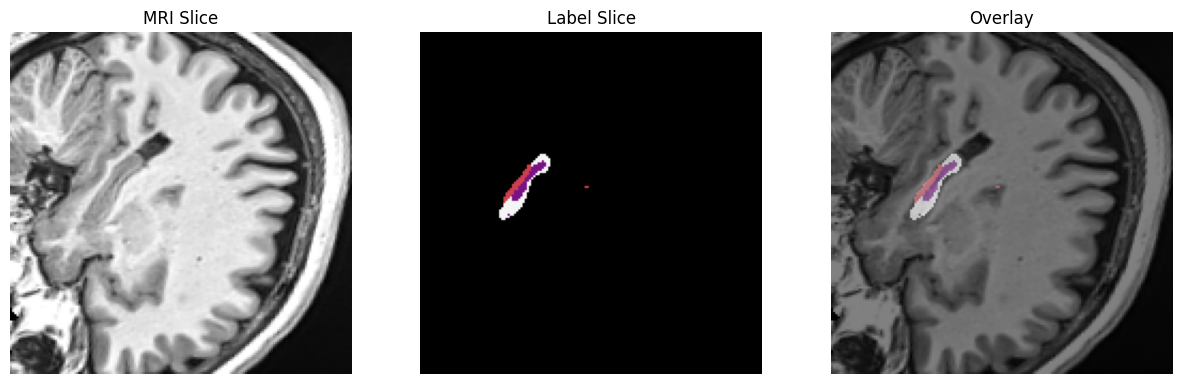

In [ ]:
#Prediction
visualize_image(val_img_np,std_pred_label, 50, array = True)

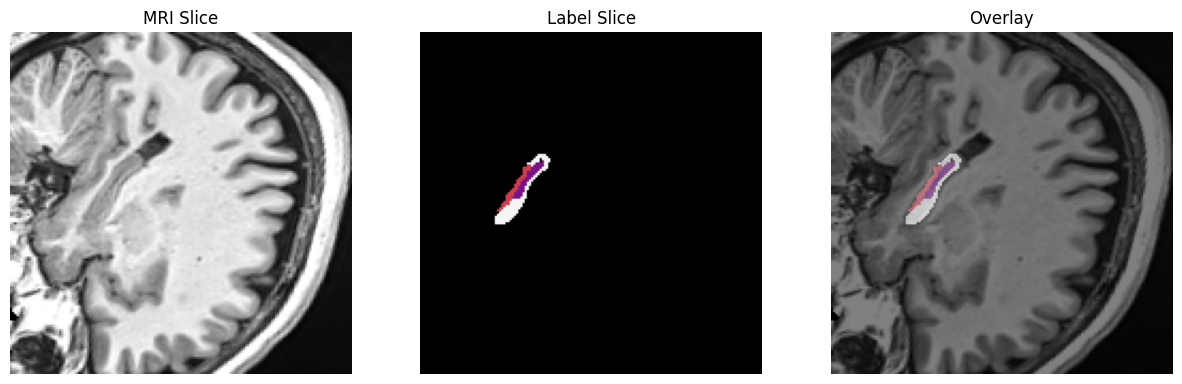

In [ ]:
#Ground Truth
visualize_image(val_img_np, std_val_seg, 50, array = True)